In [1]:
%matplotlib notebook

from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib

import cpvlib

In [2]:
lat, lon = 40.4, -3.7

tilt = lat - 10

In [3]:
data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

alt = data_pvgis[2]['location']['elevation']

data_tmy = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data = data_tmy.set_index(
    data_tmy.index.map(lambda t: t.replace(year=2010)))

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=alt, tz='utc')

solpos = location.get_solarposition(data.index)

In [4]:
A_ref = 10
eff_opt = 0.83

# Soitec CX-M500

A = 7.386  # m2

corr = A_ref / A
A *= corr
cpv_mod_params = {
    "alpha_sc": 0.00,
    "gamma_ref": 3.664,
    "mu_gamma": 0.003,
    "I_L_ref": 3.861 *1.274*eff_opt *sqrt(corr),
    "I_o_ref": 0.005e-9,
    "R_sh_ref": 3461,
    "R_sh_0": 25000,
    "R_s": 0.61,
    "EgRef": 3.91,
    "cells_in_series": 240 *sqrt(corr),
    "irrad_ref":943,
    "temp_ref":64
}

cpv_UF_parameters = {
    "IscDNI_top": 1,
    "am_thld": 1.7,
    "am_uf_m_low": 0.1,
    "am_uf_m_high": -0.1,
    "ta_thld": 25,
    "ta_uf_m_low": 0.005,
    "ta_uf_m_high": 0,
    "weight_am": 0.55,
    "weight_temp": 0.45,
}

cpv_mod_params.update(cpv_UF_parameters)

In [5]:
cpv_temp_mod_params = {"eta_m": 0.32, "u_c":29.0, "u_v":0.6} # Gerstmaier, Tobias et al «Validation of the PVSyst Performance Model for the Concentrix CPV Technology»
#  Valores por defecto: u_c=29.0, u_v=0.0, eta_m=0.1, alpha_absorption=0.9

In [6]:
# calcula Pmp STC
Pdc_stc = pvlib.pvsystem.singlediode(*cpvlib.StaticCPVSystem(
    module_parameters=cpv_mod_params
    ).calcparams_pvsyst(
    effective_irradiance=1000,
    temp_cell=25))['p_mp']

eff_a = Pdc_stc / (1000 * A)

print(f'Pdc_stc={Pdc_stc:.0f} eff_a={eff_a:.2%}')

Pdc_stc=3487 eff_a=34.87%


<IPython.core.display.Javascript object>


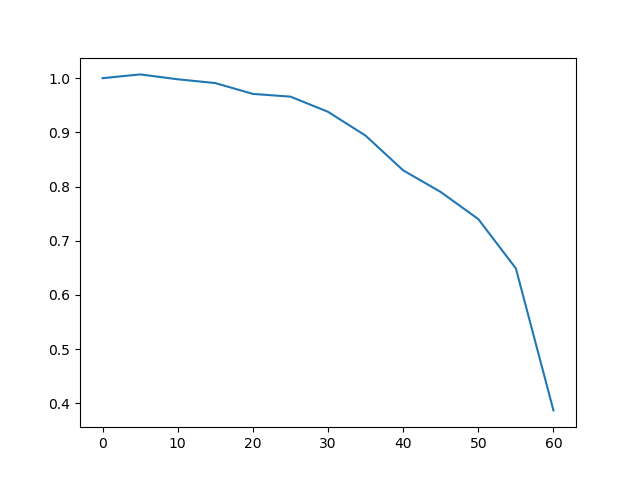

30.4
PR=0.74, Ya=1104 kWh/kW, Yr=1498 kWh/kW
Total annual energy per reference area=3850 kWh/year


C:\Users\Ruben\Documents\GitHub\StaticHybridSystem-benchmark\cpvlib.py:206: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)


In [7]:
#for tilt in range(30, 40, 1):
static_cpv_sys = cpvlib.StaticCPVSystem(
    surface_tilt=tilt,
    surface_azimuth=180,
    module_parameters=cpv_mod_params,
    temperature_model_parameters=cpv_temp_mod_params,
    modules_per_string=1,
)

irradiance = static_cpv_sys.get_irradiance(
    solpos['zenith'], solpos['azimuth'], data['dni'])

aoi = static_cpv_sys.get_aoi(
    solar_zenith=solpos['zenith'],
    solar_azimuth=solpos['azimuth'],
)

theta_ref = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
iam_ref = [1.000, 1.007, 0.998, 0.991, 0.971, 0.966, 0.938, 0.894, 0.830, 0.790, 0.740, 0.649, 0.387]

effective_irradiance = irradiance * pvlib.iam.interp(aoi, theta_ref, iam_ref, method='linear')

pd.Series(iam_ref, theta_ref).plot()

cell_temp = static_cpv_sys.pvsyst_celltemp(
    poa_global=effective_irradiance,
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

diode_parameters = static_cpv_sys.calcparams_pvsyst(
    effective_irradiance=effective_irradiance,
    temp_cell=cell_temp,
)

power = static_cpv_sys.singlediode(*diode_parameters)

data['am'] = location.get_airmass(data.index).airmass_absolute

uf_cpv = static_cpv_sys.get_am_util_factor(data['am'])

p_mp_uf = power['p_mp'] * uf_cpv

Yr = irradiance.resample('M').sum() / 1000
Ya = p_mp_uf.resample('M').sum() / Pdc_stc
Lc = Yr - Ya

PR = Ya / Yr

data_monthly = pd.concat([Yr, PR], axis='columns')
data_monthly.columns = ['Yr', 'PR']

#ax = data_monthly.plot(kind='bar', secondary_y='PR')
#ax.set_xticklabels(data.resample('M').sum().index.strftime('%b'))

print(tilt)
print(f'PR={Ya.sum()/Yr.sum():.2}, Ya={Ya.sum():.0f} kWh/kW, Yr={Yr.sum():.0f} kWh/kW')
print(f'Total annual energy per reference area={p_mp_uf.sum()/1000:.0f} kWh/year')